In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
#AND回路の説明変数と目的変数
# AND回路の入力（4サンプル、特徴量2つ）
#X (numpy.ndarray) : 入力の行列(m×n)
#mがサンプル数、nが特徴量の数
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])

# AND回路の出力
Y = np.array([[0],
              [0],
              [0],
              [1]])

In [58]:
class SimplePerceptron:
    def Sigmoid(self, value):
        """
        シグモイド関数。活性化関数の種類を変える場合変更する。
        """
        return 1.0/(1.0 + np.exp(- value))
        
    def Sigmoid_d(self, value):
        """
        シグモイド関数の微分。活性化関数の種類を変える場合変更する。
        """
        return self.Sigmoid(value) * (1.0 - self.Sigmoid(value))
    
    def ActivationFunction(self, value):
        """
        活性化関数
        """
        return self.Sigmoid(value)

    def ActivationFunction_d(self, value):
        """
        活性化関数の微分
        """
        return self.Sigmoid_d(value)
    
    def __init__(self, linear = False, times = 1000, alpha = 0.4, epsilon = 0.001, seed=0):
        """
        初期化
        
        引数:
            linear (bool) : 非線形変換はFalse。
            times        (int)  : 学習回数
            alpha        (float): 勾配降下法における係数α
            epsilon      (float): 学習を終了するJの閾値。誤差関数Jがこの値に到達したら学習停止。
            seed         (int)  : シード値
        """
        self.linear = linear
        self.W = None
        self.b = None
        self.times = times
        self.alpha = alpha
        self.epsilon = epsilon
        np.random.seed(seed)
    
    def J(self, Yh, Y):
        """
        誤差関数(推定する出力と期待する出力の誤差)を計算
        
        引数:
            Yh (numpy.ndarray): 活性化関数に代入した行列の結果(m×1の行列)。最急勾配法では傾き(微分)が0になる点を数値解析で処理するため、微分できる必要があるため0 or 1の非線形変換はしない状態である必要あり。
            Y  (numpy.ndarray): 教師データ(m×1の行列).
            
        Returnes:
            numpy.ndarray: スカラー.
        """
        # 誤差関数を計算しjに代入。分母の2.0は微分後の係数を相殺するため。
        j = ((Yh - Y) * (Yh - Y)).sum() / 2.0
        
        return j

    def Delta(self, X, Y):
        """
        最急勾配法における重みとバイアス項の偏微分項の計算
        
        引数:
            X (numpy.ndarray) : 入力の行列(m×n)
                                mがサンプル数
                                nが特徴変数の数
            Y (numpy.ndarray) : 教師データ(m×1の行列).
            
        Returns:
            numpy.ndarray : Xに繋がる重みの偏微分
            numpy.ndarray : バイアス項の偏微分
        """
        m, n = X.shape
        
        # dw(n×1の行列)を0で初期化
        dw = np.zeros((n,1))
        db = np.zeros((1,1))

        Z = X.dot(self.W) + self.b
        Yh = self.ActivationFunction(Z)
        G = self.ActivationFunction_d(Z)
        for i in range(m):
            
            # バイアス項の偏微分を計算。[0][0]はpythonは0から配列を考えるため、バイアス項bに対して1x1行列を指定する[0][0]を一意で指定する他ない。
            # δJ/δb=Σ[i(行)](Yh[i]-Y[i])*G[i]　　なお、G[i]はGにZ=X.dot(self.W) + self.である(4x1)行列を代入してできる、4x1行列のi行目の行ベクトル要素。
            db[0][0] = db[0][0] + (Yh[i]  - Y[i]) * G[i]
            
            for j in range(n): #0,1,・・・,n-1のforループとなり、[j][0]の取り扱いと整合性あり。[i]は最初のforで指定している。
                # δJ/δw[1,j]=Σ[i(行)](Yh[i]-Y[i])*G[i]*x[i,j]
                # dwは今回2x1行列でdw1,dw2があるため、dw1、dw2ごとに計算。
                dw[j][0] = dw[j][0] + (Yh[i] - Y[i]) * G[i] * X[i][j]
                
        return dw, db #dwは(2x1)行列で出力。最急勾配法の1回における偏微分項を求めるため、行ごとにdb,dw1,dw2を計算し、それの総和が最終出力ベクトルdw,dbとなる。
        
    def Fit(self, X, Y):

        # 重みとバイアス項の初期条件。wはランダム値、bは0と指定。X.shape[1]はXがmxn行列のときX.shape=(m,n)となるため、X.shape[1]はnとなる。[]は0からカウントするためmではない。
        self.W = np.random.rand(X.shape[1], 1)
        self.b = np.zeros((1,1))

        # 誤差関数の値がどう変わったのかを保存するリストを初期化
        J_List = []

        # 学習回数分だけ最急勾配法による繰り返し演算を実行。途中で閾値に達したらbreakさせる。
        for _ in range(self.times):
            Yh = self.ActivationFunction(X.dot(self.W) + self.b)

            # 誤差関数の計算
            j = self.J(Yh, Y)
            J_List.append(j)

            # 誤差がepsilon以下なら終了
            if j <= self.epsilon:
                break
                
            # 最急勾配法の実行。重みとバイアス項をforループで更新する
            dw, db = self.Delta(X, Y)
            self.W = self.W - self.alpha * dw
            self.b = self.b - self.alpha * db            

        return J_List

    def Forward(self, X):
        """
        Z: 重み付けとバイアス項の線形結合出力
        a: Zを活性化関数に代入。非線形変換(0 or 1) はif not構文で対応。
        self.linear == Falseの場合は0 or 1を返す
        self.linear == Trueの場合は、非線形変換せずに0以上1以下の値を返す
        Returns:
            numpy.ndarray: 出力の行列(m×1)
        """

        # 活性化関数への入力計算
        Z = X.dot(self.W) + self.b
        # 重みwとバイアス項bの線形結合である(4x1)行列を活性化関数に代入。出力aも(4x1)行列。
        a = self.ActivationFunction(Z)
        
        if not self.linear:
            # 0.5以上の項は1.0に、0.5未満の項は0.0にする
            return np.where(a >= 0.5, 1.0, 0.0)

        else:
            return a

Text(0, 0.5, 'error')

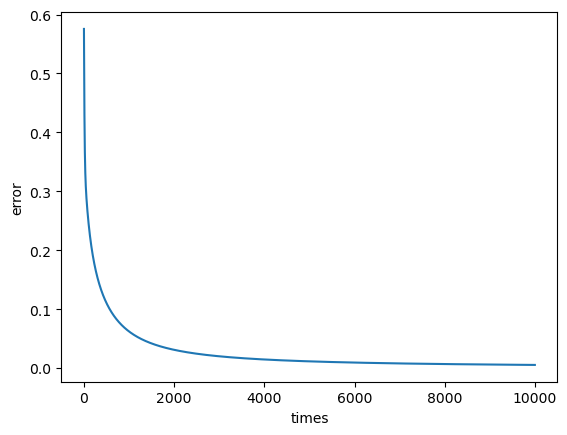

In [59]:
# モデル作成
model = SimplePerceptron(linear=False, times=10000, alpha=0.1)
error_f = model.Fit(X, Y)

# 誤差関数が小さくなっていることの確認
plt.plot(error_f)
plt.xlabel("times")
plt.ylabel("error")

In [62]:
# 最終的な重みとバイアスを出力
print("最終的な W（重み）:")
print(model.W)
print("最終的な b（バイアス）:")
print(model.b)
print("活性化関数代入前のアウトプット:")
print(X.dot(model.W) + model.b)
print("活性化関数代入後(非線形変換前)のアウトプット:")
print(model.ActivationFunction(X.dot(model.W) + model.b))
print("非線形変換を施した単純パーセプトロンによる学習最適化後の予測値:")
Y_pred = model.Forward(X)
Y_pred

最終的な W（重み）:
[[5.4818278 ]
 [5.48182781]]
最終的な b（バイアス）:
[[-8.31542316]]
活性化関数代入前のアウトプット:
[[-8.31542316]
 [-2.83359535]
 [-2.83359536]
 [ 2.64823245]]
活性化関数代入後(非線形変換前)のアウトプット:
[[2.44653449e-04]
 [5.55355153e-02]
 [5.55355151e-02]
 [9.33901965e-01]]
非線形変換を施した単純パーセプトロンによる学習最適化後の予測値:


array([[0.],
       [0.],
       [0.],
       [1.]])

In [61]:
print("関数に代入前の行列")
print(X)

print("行列をシグモイド関数に代入したときの挙動")
behavior = 1.0/(1.0 + np.exp(- X))
print(behavior)

関数に代入前の行列
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
行列をシグモイド関数に代入したときの挙動
[[0.5        0.5       ]
 [0.5        0.73105858]
 [0.73105858 0.5       ]
 [0.73105858 0.73105858]]
